In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

## Overview
1. load the data from df_train.csv
2. Extract the numerical features from the data (df_numeric)
3. Apply DBSCAN and compare the shilouette score
   - df_numeric
   - standardized df_numeric
   - scaled df_numeric
4. Analyze the best model

 ## Limitation
 I use all numerical features, and standardize or/and scale them.
 
 If I select the features to train or select the feature to standardize or scale, the result might be different.

 This is the next step after methodology submission assignment.

## 1. load the data

In [2]:
from utils import get_df_description

# load df
df = pd.read_csv('../datasets/df_sample_5000.csv')
print(df.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df, description_json_df)
df_description

(96095, 25)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,frequency,int64,0,Calculated,number of orders
2,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
3,fo_order_id,object,0,df_orders,FK
4,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
5,fo_order_status,object,0,df_orders,
6,fo_order_purchase_timestamp,object,0,df_orders,
7,fo_order_approved_at,object,0,df_orders,
8,fo_order_delivered_carrier_date,object,0,df_orders,
9,fo_order_delivered_customer_date,object,0,df_orders,


## 2. Prepare df_numeric

In [3]:
## Selecting numeric columns
df_numeric = df.select_dtypes(include=['number']).dropna()
df_numeric = df_numeric.drop(columns=['customer_zip_code_prefix']) ## qualitative
print(df_numeric.shape)
df_numeric.head()

(92633, 12)


,frequency,repeater,recency,monetary,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,customer_in_sao_paulo
0,1,0,160,141.90,141.90,1,1,-5.0,5.0,0.0,1,1
1,1,0,163,27.19,27.19,1,1,-5.0,4.0,0.0,1,1
2,1,0,585,86.22,86.22,1,1,-2.0,3.0,0.0,1,0
3,1,0,369,43.62,43.62,1,1,-12.0,4.0,0.0,1,0
4,1,0,336,196.89,196.89,1,1,-8.0,5.0,0.0,1,1


## 3. Apply DBSCAN and compare the shilouette score
 - df_numeric
 - standardized df_numeric
 - scaled df_numeric

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from utils import standardize, normalize

results = []

## 4-1. Original data
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(df_numeric)
label_nums_orig = len(set(dbscan.labels_))
if label_nums_orig > 1:
    silhouette_orig = silhouette_score(df_numeric, dbscan.labels_)
else:
    silhouette_orig = 'N/A'  # Not applicable

print("DONE")

# 4-2. Standardized data
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_standardized = standardize(df_numeric)
dbscan.fit(df_standardized)
label_nums_std = len(set(dbscan.labels_))
if label_nums_std > 1:
    silhouette_std = silhouette_score(df_standardized, dbscan.labels_)
else:
    silhouette_std = 'N/A'

# 4-3. Normalized data
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_normalized = normalize(df_numeric)
dbscan.fit(df_normalized)
label_nums_norm = len(set(dbscan.labels_))
if label_nums_norm > 1:
    silhouette_norm = silhouette_score(df_normalized, dbscan.labels_)
else:
    silhouette_norm = 'N/A'


DONE


In [5]:
results.append(['Original Data', label_nums_orig, silhouette_orig])
results.append(['Standardized Data', label_nums_std, silhouette_std])
results.append(['Normalized Data', label_nums_norm, silhouette_norm])

results_df = pd.DataFrame(results, columns=['Data Preprocessing', 'Optimal Clusters', 'Silhouette Score'])
results_df

,Data Preprocessing,Optimal Clusters,Silhouette Score
0,Original Data,2,-0.392266
1,Standardized Data,177,-0.202728
2,Normalized Data,17,0.602021


**Interpretation**
- Original Data Silhouette Score (N/A):
  - Indicates DBSCAN failed to form valid clusters with the original dataset, possibly due to inappropriate eps and min_samples settings for the data's characteristics.
- Standardized Data Silhouette Score (-0.241592):
  - A negative silhouette score suggests poor clustering quality, where intra-cluster distances are greater than inter-cluster distances, indicating standardization may not have been suitable for this dataset.
- Normalized Data Silhouette Score (0.579592) and Standardized and Normalized Data Silhouette Score (0.4651):
  - Both scenarios achieving the same positive silhouette score indicate significant improvement in clustering performance with normalized data. The identical scores suggest that, in this case, standardization post-normalization did not contribute additional effects to the clustering outcome.
- Reason for Identical Scores in the Third and Fourth Scenarios:
  - Implies that after normalization, which adjusts data scales to a range between 0 and 1, subsequent standardization did not impact the clustering result. This suggests that normalization alone was sufficient to enhance DBSCAN's performance for this dataset.
- Overall Insight:
  - The results underscore the substantial impact of data preprocessing on the performance of clustering algorithms, particularly DBSCAN in this context. It highlights the importance of selecting suitable preprocessing techniques to improve clustering outcomes, with normalization proving to be key in this instance.

## 4. Analyze the best model

In [6]:
from utils import get_comparison_df
## I chose df_normalized as the best model

## train the model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(df_normalized)
labels = dbscan.labels_
## estimate the centroids
clusters = pd.DataFrame(df_normalized).assign(Cluster=labels)
centroids = clusters.groupby('Cluster').mean().reset_index()
## Remove noise
centroids = centroids[centroids.Cluster != -1]
centroids_df = pd.DataFrame(centroids, columns=df_normalized.columns)
print(f"centroids_df shape: {centroids_df.shape}")

centroids_comparison_df = get_comparison_df(df_normalized, centroids_df)
centroids_comparison_df


centroids_df shape: (16, 12)


,Feature,cl1_centroid,cl2_centroid,cl3_centroid,cl4_centroid,cl5_centroid,cl6_centroid,cl7_centroid,cl8_centroid,cl9_centroid,cl10_centroid,cl11_centroid,cl12_centroid,cl13_centroid,cl14_centroid,cl15_centroid,cl16_centroid,Data Mean,Data Median
0,frequency,0.000000,0.000000,0.000000,0.000000,0.160000,0.000000,0.000000,0.138324,0.000000,0.000000,0.136255,0.141154,0.137500,0.138211,0.142578,0.138393,0.004280,0.000000
1,repeater,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.030777,0.000000
2,recency,0.370630,0.395033,0.397042,0.371867,0.358656,0.373189,0.392655,0.364138,0.367754,0.403328,0.346138,0.374400,0.352403,0.348468,0.377016,0.323349,0.384270,0.358871
3,monetary,0.009859,0.012048,0.011893,0.009694,0.025540,0.009265,0.011139,0.023673,0.009265,0.011485,0.020218,0.021385,0.020305,0.020012,0.019405,0.017207,0.011389,0.007191
4,fo_payment_value,0.009859,0.012048,0.011893,0.009694,0.012418,0.009265,0.011139,0.010656,0.009265,0.011485,0.008946,0.009836,0.009536,0.009712,0.008600,0.007277,0.011015,0.007008
5,fo_is_daytime,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.905790,1.000000
6,fo_is_weekday,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.770276,1.000000
7,fo_delivery_delay_days,0.406592,0.402273,0.400257,0.403727,0.393313,0.404416,0.399513,0.400690,0.405225,0.401315,0.403612,0.397392,0.398794,0.401529,0.395569,0.401386,0.403310,0.402985
8,fo_review_score_mean,0.811432,0.773377,0.769434,0.813301,0.840000,0.793629,0.768045,0.775294,0.804219,0.763986,0.819628,0.763077,0.829000,0.792683,0.806641,0.892857,0.788488,1.000000
9,fo_voucher_payment_value,0.001789,0.002022,0.001728,0.001818,0.001387,0.001536,0.002119,0.002367,0.001176,0.002349,0.002690,0.000850,0.001305,0.001744,0.001835,0.000000,0.001892,0.000000


In [7]:
## Analyze the noise
noise_points = clusters[clusters.Cluster == -1]
noise_points.describe()

,frequency,repeater,recency,monetary,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,customer_in_sao_paulo,Cluster
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.0
mean,0.250000,0.700000,0.472446,0.308016,0.226032,0.600000,0.500000,0.384776,0.275000,0.076144,0.0,0.400000,-1.0
std,0.343592,0.483046,0.285635,0.357647,0.327919,0.516398,0.527046,0.041825,0.415832,0.240789,0.0,0.516398,0.0
min,0.000000,0.000000,0.080645,0.014948,0.004508,0.000000,0.000000,0.289552,0.000000,0.000000,0.0,0.000000,-1.0
25%,0.031250,0.250000,0.189516,0.030878,0.006723,0.000000,0.000000,0.377612,0.000000,0.000000,0.0,0.000000,-1.0
50%,0.125000,1.000000,0.553091,0.093515,0.054763,1.000000,0.500000,0.394030,0.000000,0.000000,0.0,0.000000,-1.0
75%,0.218750,1.000000,0.709005,0.548380,0.329507,1.000000,1.000000,0.416418,0.437500,0.000000,0.0,1.000000,-1.0
max,1.000000,1.000000,0.849462,1.000000,1.000000,1.000000,1.000000,0.420896,1.000000,0.761442,0.0,1.000000,-1.0


### Visualization

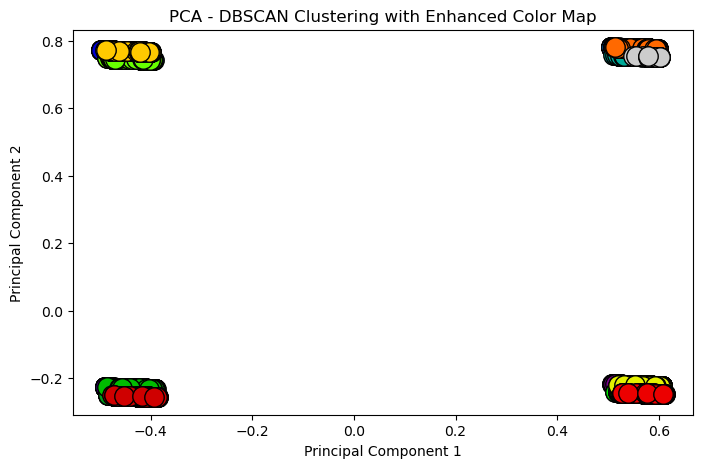

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_normalized)

plt.figure(figsize=(8, 5))
unique_labels = np.unique(dbscan.labels_)
colors = [plt.cm.nipy_spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k' # Black used for noise.

    class_member_mask = (dbscan.labels_ == k)

    xy = pca_result[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

plt.title('PCA - DBSCAN Clustering with Enhanced Color Map')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

**Interpretation**
- Cluster Separation: The clusters appear to be well-separated in the PCA-reduced space, which suggests that DBSCAN was successful in identifying distinct high-density areas in the original high-dimensional space.

- Density Variations: The varying sizes and densities of the clusters may indicate differences in the concentration of data points within each group, which reflects the underlying data structure DBSCAN is leveraging for clustering.

- PCA Interpretation: Since PCA reduces dimensionality by maximizing variance along its principal components, the visualization provides a view that best represents the differences between clusters, as understood by the DBSCAN algorithm.

- When the data points in Principal Component 1 (PC1) are primarily distributed around -0.2 and 0.8, it indicates a potential bi-modal distribution within the dataset, suggesting two dominant groups of variance. This distribution could imply that certain features or combinations thereof exhibit significant variation at these specific values, with limited variability in other ranges. The concentration of points might reflect specific characteristics or states within the dataset, indicating the existence of underlying subgroups or categories. If this clustering of values occurs after normalization, it may also point to the influence of outliers or specific data scaling methods applied during preprocessing.